In [1]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler, MaxAbsScaler, scale, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kurtosis, skew
from string import ascii_letters
import featuretools as ft
import warnings
warnings.filterwarnings("ignore")
import os
os.getcwd()
sns.set(style="darkgrid")

In [46]:
! pip install featuretools

    100% |████████████████████████████████| 143kB 21.1MB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/5d/d4/6e9c56a561f1d27407bf29318ca43f36ccaa289271b805a30034eb3a8ec4/pandas-0.23.4-cp35-cp35m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 51kB 19.5MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 20.3MB/s ta 0:00:01
    100% |████████████████████████████████| 184kB 26.8MB/s ta 0:00:01
    100% |████████████████████████████████| 675kB 22.4MB/s ta 0:00:01
    100% |████████████████████████████████| 4.7MB 6.4MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 25.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 22.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for featuretools ... done
  Stored in directory: /content/.cache/pip/wheels/96/f8/54/2972818f8d9d33f3fe6316bbb23e2d6048c5afd8561c12eeb8
  Running setup.py bdist_wheel for s3fs ... done
  Stor

In [2]:
! pip install missingno

In [24]:
import missingno as msno
from io import BytesIO as BI
%matplotlib inline
# import all data
%gcs read --object "gs://deft-tube-217903/Home Credit/bureau.csv" --variable csv_as_bytes
bureau = pd.read_csv(BI(csv_as_bytes))

%gcs read --object "gs://deft-tube-217903/Home Credit/application_train.csv" --variable csv_as_bytes
app_train = pd.read_csv(BI(csv_as_bytes))

%gcs read --object "gs://deft-tube-217903/Home Credit/application_test.csv" --variable csv_as_bytes
app_test = pd.read_csv(BI(csv_as_bytes))

%gcs read --object "gs://deft-tube-217903/Home Credit/bureau_balance.csv" --variable csv_as_bytes
bureau_balance = pd.read_csv(BI(csv_as_bytes))

%gcs read --object "gs://deft-tube-217903/Home Credit/credit_card_balance.csv" --variable csv_as_bytes
cre_balance = pd.read_csv(BI(csv_as_bytes))

%gcs read --object "gs://deft-tube-217903/Home Credit/installments_payments.csv" --variable csv_as_bytes
ins_payments = pd.read_csv(BI(csv_as_bytes))

%gcs read --object "gs://deft-tube-217903/Home Credit/previous_application.csv" --variable csv_as_bytes
pre_application = pd.read_csv(BI(csv_as_bytes))

%gcs read --object "gs://deft-tube-217903/Home Credit/POS_CASH_balance.csv" --variable csv_as_bytes
POS_balance = pd.read_csv(BI(csv_as_bytes))

This uncovers the unimbalance class problem that needs to be taken account into the modelling and validation stages.

## Column Types

In [5]:
# Identify and sum up all the column types over all dataframes
filelist = (app_test,bureau,bureau_balance,cre_balance,ins_payments,pre_application,POS_balance)
MissSum = app_train.dtypes.value_counts().to_dict()
UniqCat = []
  
for file in filelist:
  Miss = file.dtypes.value_counts().to_dict()
  MissSum = {key: Miss.get(key, 0) + MissSum.get(key, 0)
             for key in set(Miss) | set(MissSum)}
  for column in file.columns:
    if file[column].dtypes == 'object':
      UniqCat.append(file[column].nunique())

Table = pd.DataFrame.from_dict(MissSum, orient = 'index')
Table.columns = ['Cols']
Table

,Cols
float64,175
object,54
int64,110


### Categorical Variables

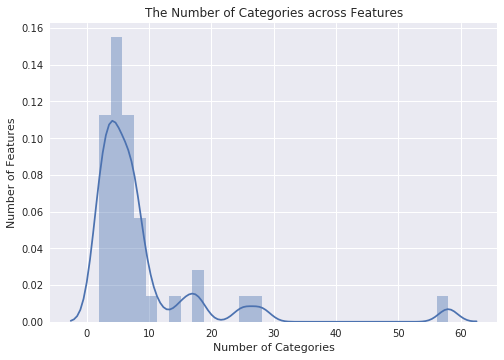

In [6]:
ax = sns.distplot(UniqCat, bins = 30, norm_hist = True)
ax.set(xlabel = 'Number of Categories', ylabel = 'Number of Features', title = 'The Number of Categories across Features')
plt.show()

In [10]:
# The number of new columns after one-hot-encoding
sum(UniqCat)

327

If we resort to one hot encoding, there would be 327 new columns, even more than the number of original features. Feature selection tools may end up dropping a proportion of them that are actually explanatory. One way to get around witht the high dimensionality is to consider the combination of label-encoding and tree-based models. However, random forest, as a popular feature selection method, is known to favor feature with more categories and thus overfit. There are actually more advanced methods that overcome the drawback of random forest, such as extremely randomized forests, and permutation importance. Therefore, label-encoding is chosen.

Other benchmark models such as generalised linear model and genrealised additive model require the one-hot encoding since the label-encoding would not make sense for them. For now, we proceed with label-encoded variables.

## Missing Values

### NaN in application_train

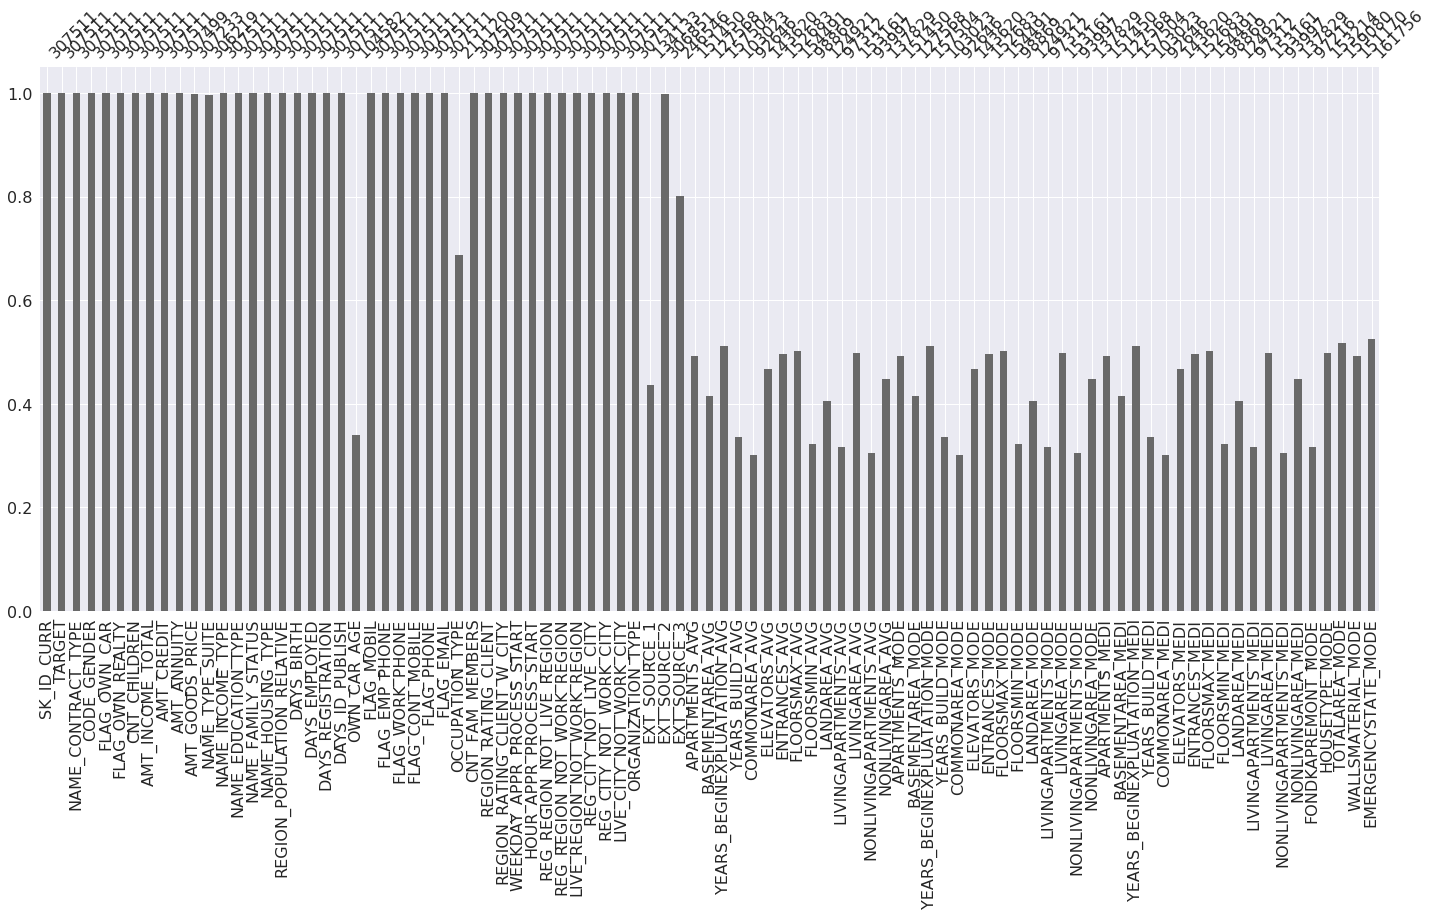

In [12]:
msno.bar(app_train.iloc[:,:91])

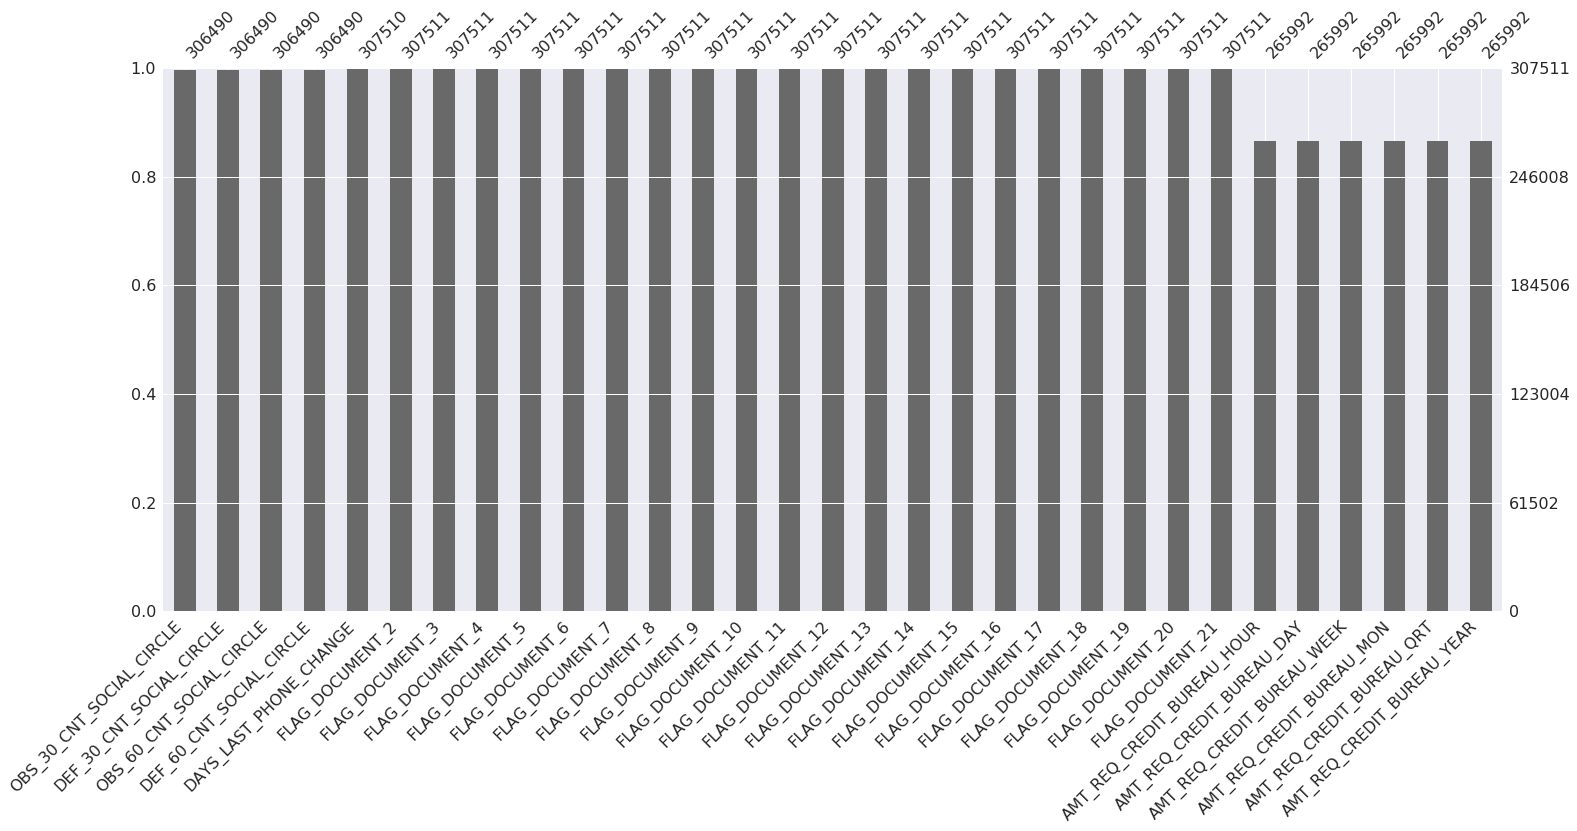

In [17]:
msno.bar(app_train.iloc[:,-31:])

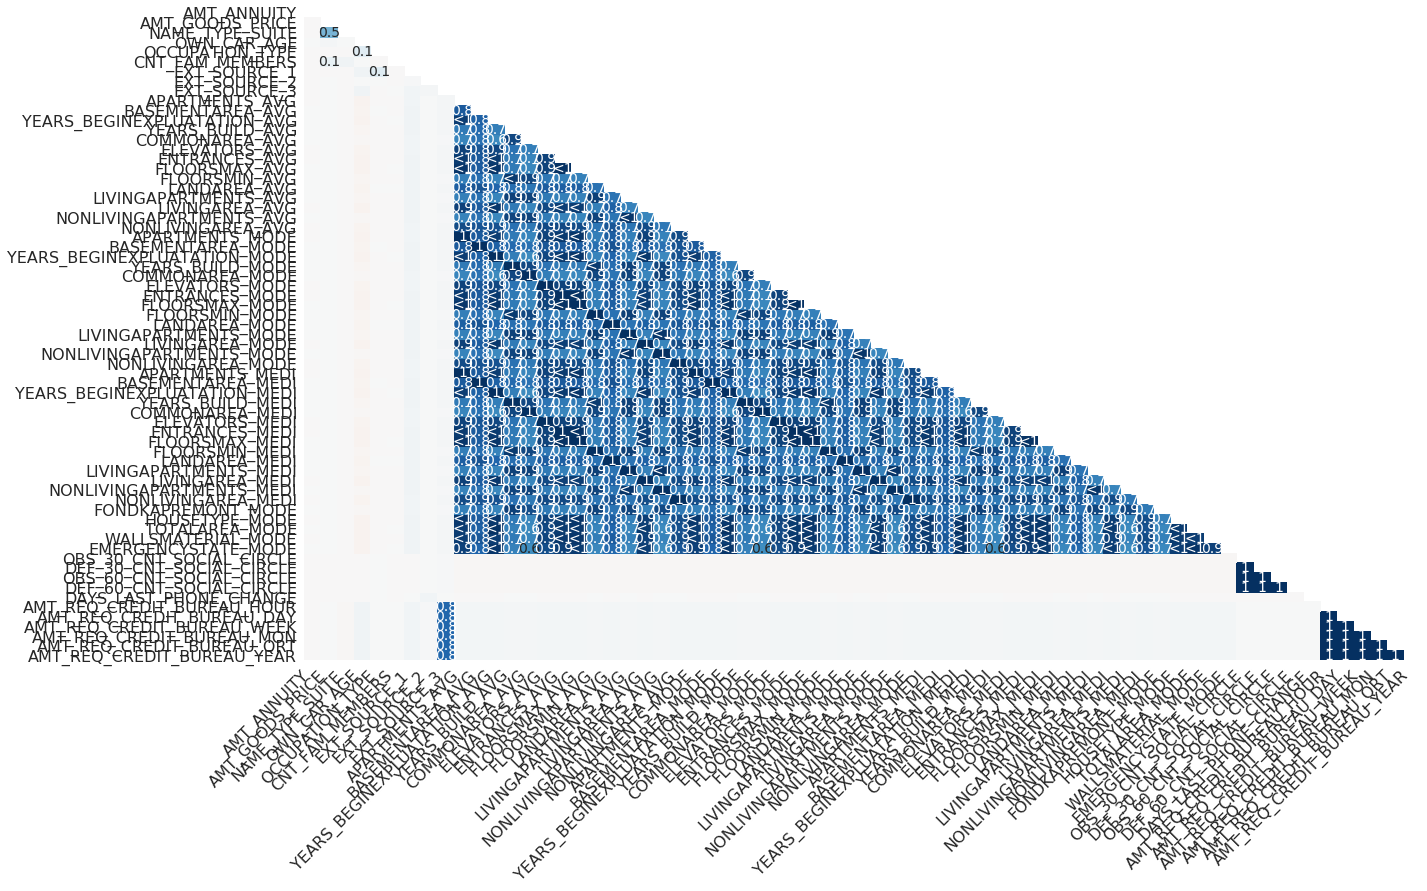

In [115]:
msno.heatmap(app_train[app_train.columns[app_train.isna().any()].tolist()])

Interpretation of the correlations: https://github.com/ResidentMario/missingno

Potential new features related to the number of missing columns. The reason is that more missing values may be correlated with higher probability of default.

In [15]:
# Locate the negative variables
minmissing = app_train.loc[:,app_train.columns[app_train.isna().any()].tolist()].min()
minmissing[minmissing < 0]

DAYS_LAST_PHONE_CHANGE   -4292.0
dtype: float64

In [11]:
app_train['DAYS_LAST_PHONE_CHANGE'].max()

0.0

1. Fill the missing value of DAYS_ variable by positive integer, 1.
2. Fill all the other variables' missing values by -1.

In [19]:
app_train.loc[app_train['DAYS_LAST_PHONE_CHANGE'].isnull(), 'DAYS_LAST_PHONE_CHANGE']

15709   NaN
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

For 'DAYS_LAST_PHONE_CHANGE', there is only one row with missing value, so this is just replaced by the mean. 

In [25]:
# Fill missing value of 'DAYS_LAST_PHONE_CHANGE' with mean
app_train['DAYS_LAST_PHONE_CHANGE'].fillna(value = np.mean(app_train['DAYS_LAST_PHONE_CHANGE']), inplace = True)

The rest of columns in application_train have non-negative values. This indicates means that filling NaN with negative numbers could differentiate them from other values.

In [19]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
catlist = app_train.select_dtypes(exclude=['object']).columns
app_train2 = app_train[catlist].fillna(-1)
app_train[catlist] = app_train2

In [27]:
app_train.columns[app_train.isna().any()].tolist()

['NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

### NaN in Application_Test

In [29]:
# Locate the negative variables
minmissing = app_test.loc[:,app_test.columns[app_test.isna().any()].tolist()].min()
minmissing[minmissing < 0]

Series([], dtype: float64)

In [30]:
catlist = app_test.select_dtypes(exclude=['object']).columns
app_test2 = app_test[catlist].fillna(-1)
app_test[catlist] = app_test2

### NaN in Previous_application

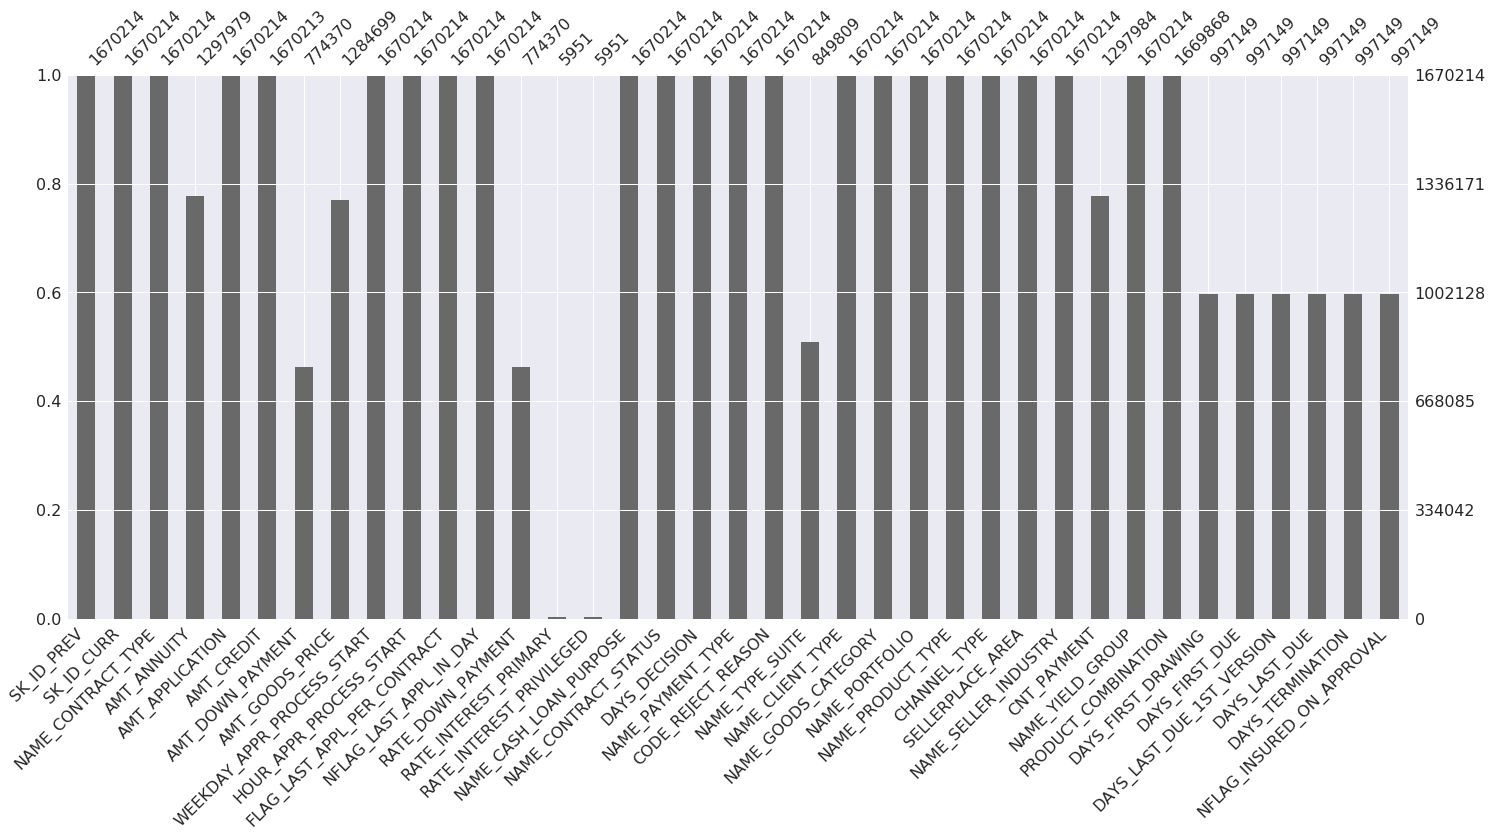

In [106]:
msno.bar(pre_application.iloc[:,:])

In [111]:
# The proportion of non-null values for RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEGED
pre_application.iloc[:,14].count()/ pre_application.iloc[:,0].count()

0.0035630164757330498

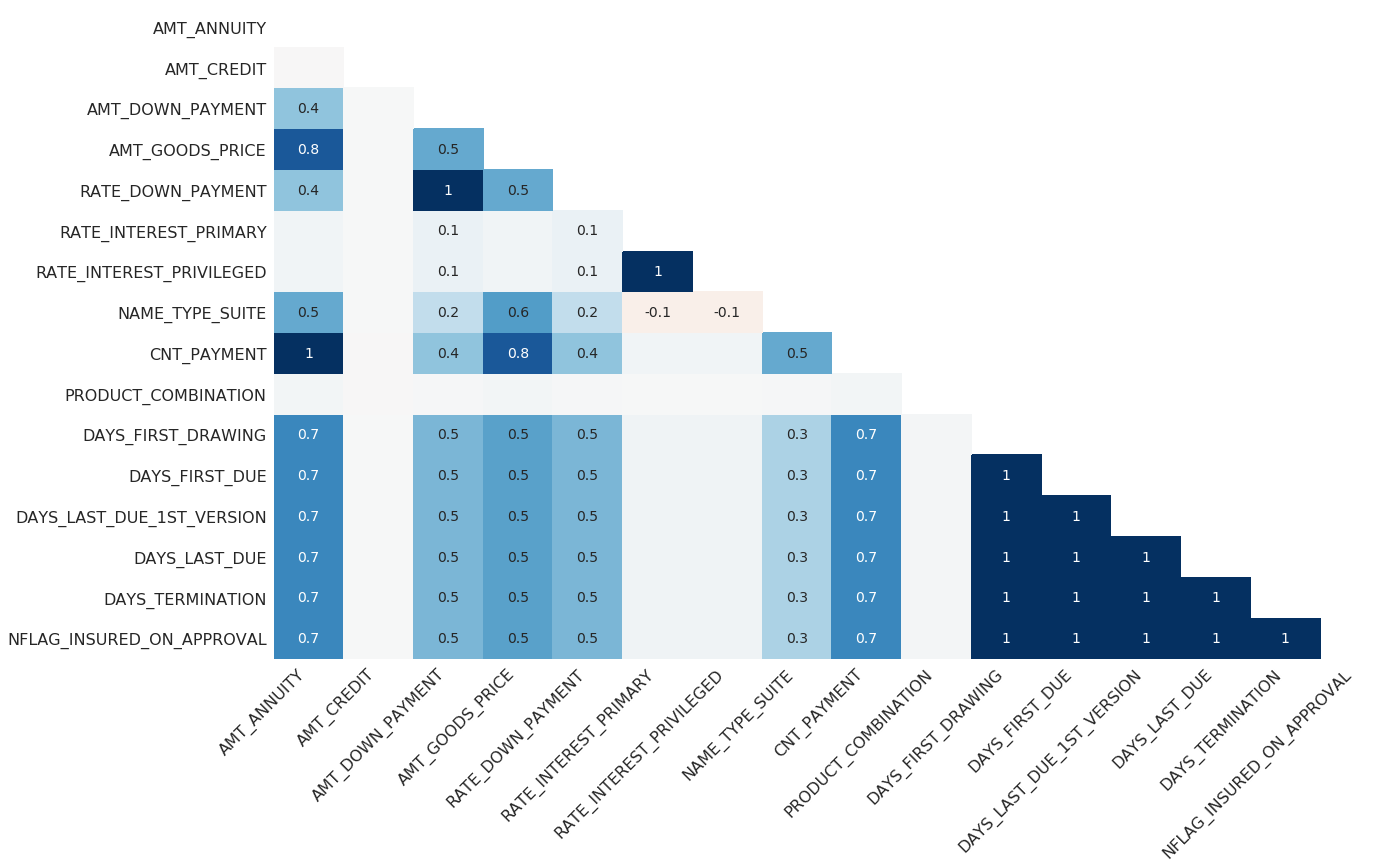

In [114]:
msno.heatmap(pre_application[pre_application.columns[pre_application.isna().any()].tolist()])

In [132]:
pre_application.loc[pre_application['AMT_CREDIT'].isnull(),['SK_ID_CURR','AMT_CREDIT']]

,SK_ID_CURR,AMT_CREDIT
1127152,438387,NaN


In [27]:
pre_application.loc[:,pre_application.columns[pre_application.isna().any()].tolist()].min()

AMT_ANNUITY                     0.000000
AMT_CREDIT                      0.000000
AMT_DOWN_PAYMENT                0.000000
AMT_GOODS_PRICE                 0.000000
RATE_DOWN_PAYMENT               0.000000
RATE_INTEREST_PRIMARY           0.034781
RATE_INTEREST_PRIVILEGED        0.373150
CNT_PAYMENT                     0.000000
DAYS_FIRST_DRAWING          -2922.000000
DAYS_FIRST_DUE              -2892.000000
DAYS_LAST_DUE_1ST_VERSION   -2801.000000
DAYS_LAST_DUE               -2889.000000
DAYS_TERMINATION            -2874.000000
NFLAG_INSURED_ON_APPROVAL       0.000000
dtype: float64

In [37]:
pre_application.loc[:,pre_application.columns[pre_application.isna().any()].tolist()].select_dtypes(include='object').columns

Index(['NAME_TYPE_SUITE', 'PRODUCT_COMBINATION'], dtype='object')

In [142]:
pre_application.loc[:,pre_application.columns[pre_application.isna().any()].tolist()].max()

AMT_ANNUITY                   418058.145
AMT_CREDIT                   6905160.000
AMT_DOWN_PAYMENT             3060045.000
AMT_GOODS_PRICE              6905160.000
RATE_DOWN_PAYMENT                  1.000
RATE_INTEREST_PRIMARY              1.000
RATE_INTEREST_PRIVILEGED           1.000
CNT_PAYMENT                       84.000
DAYS_FIRST_DRAWING            365243.000
DAYS_FIRST_DUE                365243.000
DAYS_LAST_DUE_1ST_VERSION     365243.000
DAYS_LAST_DUE                 365243.000
DAYS_TERMINATION              365243.000
NFLAG_INSURED_ON_APPROVAL          1.000
dtype: float64

In [70]:
pre_application.loc[pre_application['RATE_DOWN_PAYMENT'] < 0,:]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL


In [71]:
pre_application.loc[pre_application['RATE_DOWN_PAYMENT'] < 0,['RATE_DOWN_PAYMENT','AMT_DOWN_PAYMENT']] = 0

The negative values for 'AMT_DOWN_PAYMENT' and 'RATE_DOWN_PAYMENT" are supposed to be positive. For simplicity, they are changed to 0.

In [63]:
pre_application.sort_values('DAYS_FIRST_DRAWING', ascending=False).drop_duplicates(['DAYS_FIRST_DRAWING'])['DAYS_FIRST_DRAWING'].head()

0          365243.0
1271047        -2.0
1553991        -3.0
707880         -4.0
528993         -5.0
Name: DAYS_FIRST_DRAWING, dtype: float64

In [66]:
pre_application.sort_values('DAYS_FIRST_DUE', ascending=False).drop_duplicates(['DAYS_FIRST_DUE'])['DAYS_FIRST_DUE'].head()

285608     365243.0
579654         -2.0
62012          -3.0
1632323        -4.0
197020         -5.0
Name: DAYS_FIRST_DUE, dtype: float64

In [65]:
pre_application.sort_values('DAYS_LAST_DUE_1ST_VERSION', ascending=False).drop_duplicates(['DAYS_LAST_DUE_1ST_VERSION'])['DAYS_LAST_DUE_1ST_VERSION'].head()

989646     365243.0
1363511      2389.0
1224503      2098.0
645393       2090.0
1207872      2032.0
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

In [67]:
pre_application.sort_values('DAYS_LAST_DUE', ascending=False).drop_duplicates(['DAYS_LAST_DUE'])['DAYS_LAST_DUE'].head()

1068278    365243.0
63798          -2.0
361922         -3.0
586207         -4.0
1453970        -5.0
Name: DAYS_LAST_DUE, dtype: float64

In [68]:
pre_application.sort_values('DAYS_TERMINATION', ascending=False).drop_duplicates(['DAYS_TERMINATION'])['DAYS_TERMINATION'].head()

1082810    365243.0
689875         -2.0
756605         -3.0
544853         -4.0
351463         -5.0
Name: DAYS_TERMINATION, dtype: float64

Obviously 365243 is a manually picked value to represent certain meaning. 

In [32]:
# Do not fill categorical variables # Fill all NaN of categorical variables by -1
# pre_application['PRODUCT_COMBINATION'].fillna(-1, inplace = True)
# pre_application['NAME_TYPE_SUITE'].fillna(-1, inplace = True)
# Fill all non-negative continuous variables by -1
pre_application['AMT_ANNUITY'].fillna(-1, inplace = True)
pre_application['AMT_CREDIT'].fillna(-1, inplace = True)
pre_application['AMT_DOWN_PAYMENT'].fillna(-1, inplace = True)
pre_application['AMT_GOODS_PRICE'].fillna(-1, inplace = True)
pre_application['RATE_DOWN_PAYMENT'].fillna(-1, inplace = True)
pre_application['RATE_INTEREST_PRIMARY'].fillna(-1, inplace = True)
pre_application['RATE_INTEREST_PRIVILEGED'].fillna(-1, inplace = True)
pre_application['CNT_PAYMENT'].fillna(-1, inplace = True)
pre_application['NFLAG_INSURED_ON_APPROVAL'].fillna(-1, inplace = True)
# Fill DAYS variables except 'DAYS_LAST_DUE_1ST_VERSION' by 1 since the majority is non-positive and only one positive value of 365243
pre_application['DAYS_FIRST_DRAWING'].fillna(1, inplace = True)
pre_application['DAYS_FIRST_DUE'].fillna(1, inplace = True)
pre_application['DAYS_LAST_DUE'].fillna(1, inplace = True)
pre_application['DAYS_TERMINATION'].fillna(1, inplace = True)
# Fill 'DAYS_LAST_DUE_1ST_VERSION' by 10,000, which is between the second and first highest unique value (2389, 365243)
pre_application['DAYS_LAST_DUE_1ST_VERSION'].fillna(10000, inplace = True)

### NaN in Bureau

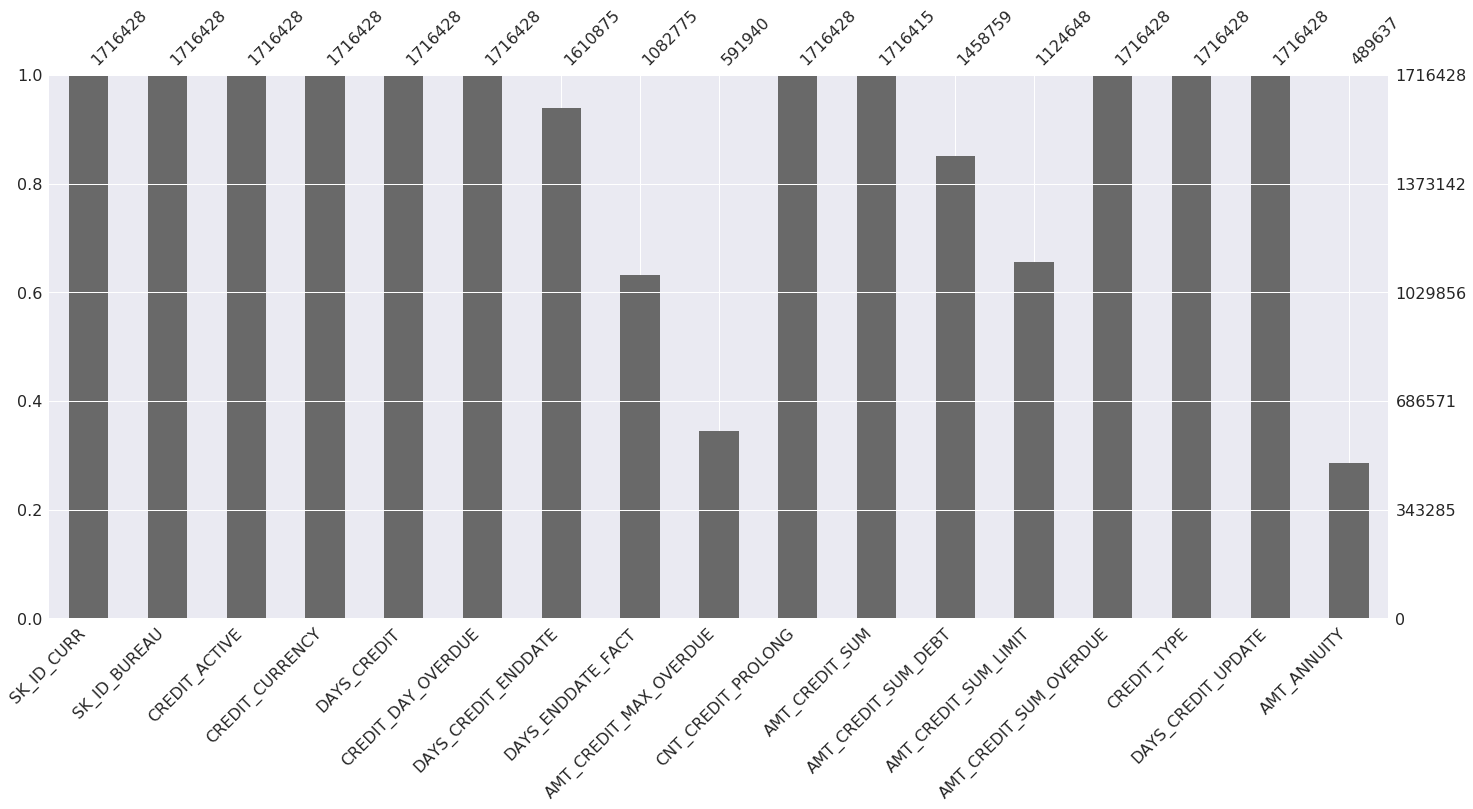

In [156]:
msno.bar(bureau)

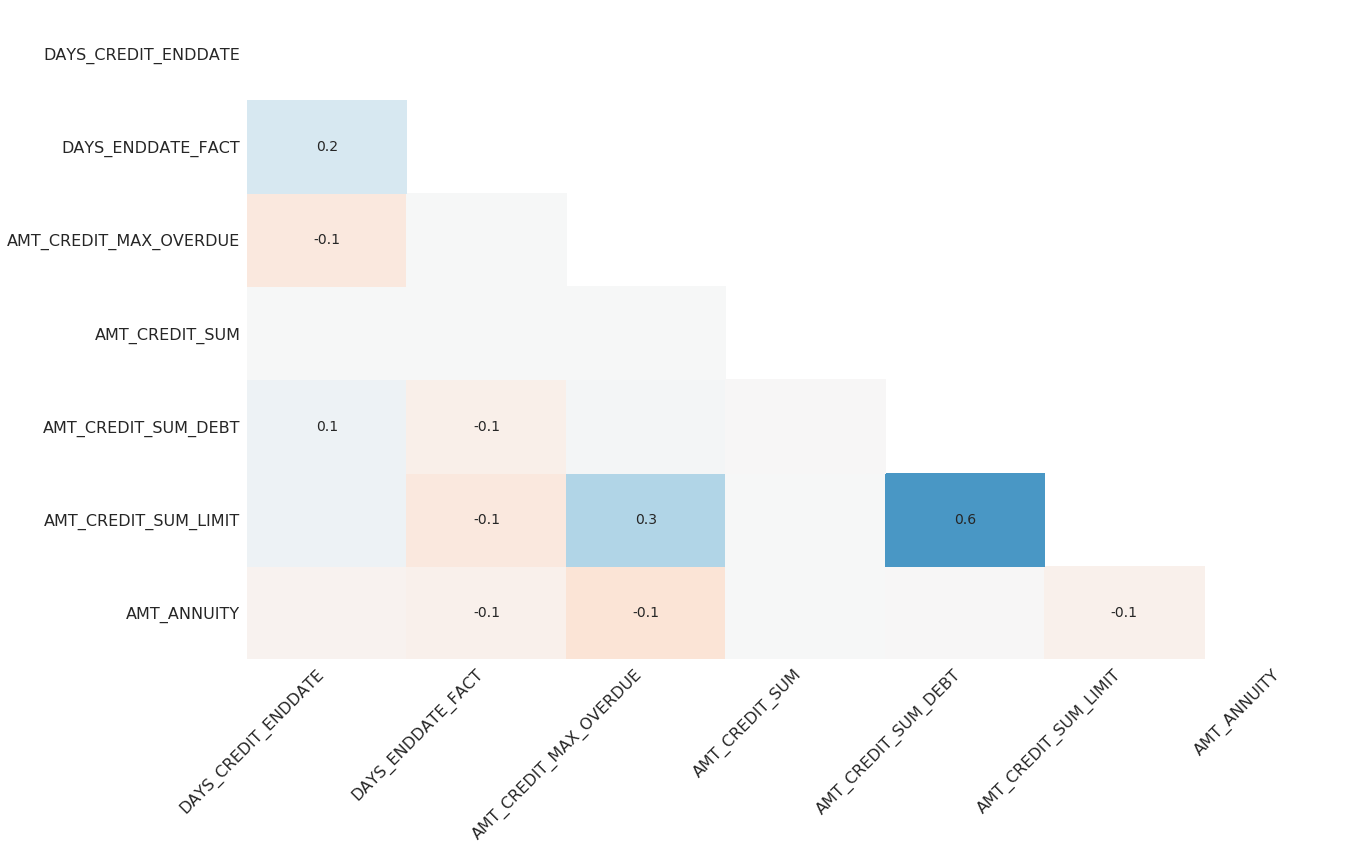

In [162]:
msno.heatmap(bureau[bureau.columns[bureau.isna().any()].tolist()])

In [112]:
bureau.columns[bureau.isna().any()].tolist()

['DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_ANNUITY']

In [114]:
bureau.loc[:,bureau.columns[bureau.isna().any()].tolist()].min()

DAYS_CREDIT_ENDDATE        -42060.000
DAYS_ENDDATE_FACT          -42023.000
AMT_CREDIT_MAX_OVERDUE          0.000
AMT_CREDIT_SUM                  0.000
AMT_CREDIT_SUM_DEBT      -4705600.320
AMT_CREDIT_SUM_LIMIT      -586406.115
AMT_ANNUITY                     0.000
dtype: float64

In [113]:
bureau.loc[:,bureau.columns[bureau.isna().any()].tolist()].max()

DAYS_CREDIT_ENDDATE       3.119900e+04
DAYS_ENDDATE_FACT         0.000000e+00
AMT_CREDIT_MAX_OVERDUE    1.159872e+08
AMT_CREDIT_SUM            5.850000e+08
AMT_CREDIT_SUM_DEBT       1.701000e+08
AMT_CREDIT_SUM_LIMIT      4.705600e+06
AMT_ANNUITY               1.184534e+08
dtype: float64

In [115]:
bureau.sort_values('DAYS_CREDIT_ENDDATE', ascending=False).drop_duplicates(['DAYS_CREDIT_ENDDATE'])['DAYS_CREDIT_ENDDATE'].head()

1168469    31199.0
384847     31198.0
683186     31197.0
501677     31196.0
1625559    31195.0
Name: DAYS_CREDIT_ENDDATE, dtype: float64

In [117]:
bureau.sort_values('AMT_CREDIT_SUM_DEBT', ascending=False).drop_duplicates(['AMT_CREDIT_SUM_DEBT'])['AMT_CREDIT_SUM_DEBT'].head()

489961     170100000.0
488411     164032200.0
1653626     65441403.0
1609469     64570243.5
1701166     62218953.0
Name: AMT_CREDIT_SUM_DEBT, dtype: float64

In [118]:
bureau.sort_values('AMT_CREDIT_SUM_LIMIT', ascending=False).drop_duplicates(['AMT_CREDIT_SUM_LIMIT'])['AMT_CREDIT_SUM_LIMIT'].head()

82859      4705600.320
882676     4500000.000
1430873    4443255.000
1160234    3555065.655
277448     3375000.000
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

Fill -1 for DAYS, fill 1 for AMT

In [34]:
bureau['DAYS_CREDIT_ENDDATE'].fillna(1, inplace = True)
bureau['DAYS_ENDDATE_FACT'].fillna(1, inplace = True)
bureau['AMT_CREDIT_MAX_OVERDUE'].fillna(-1, inplace = True)
bureau['AMT_CREDIT_SUM'].fillna(-1, inplace = True)
bureau['AMT_CREDIT_SUM_DEBT'].fillna(-1, inplace = True)
bureau['AMT_CREDIT_SUM_LIMIT'].fillna(-1, inplace = True)
bureau['AMT_ANNUITY'].fillna(-1, inplace = True)

### NaN in credit_card_balance

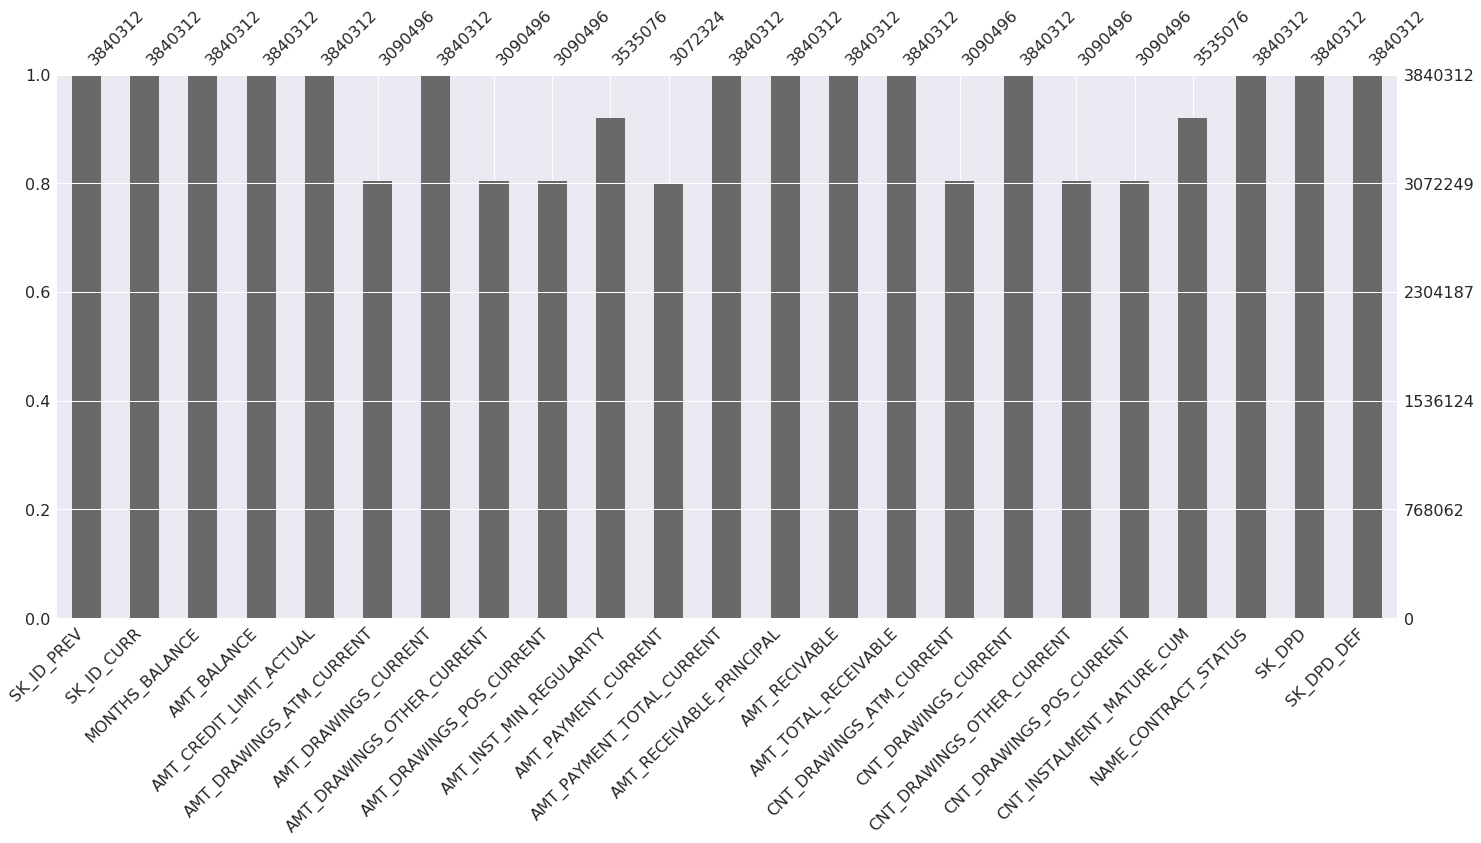

In [161]:
msno.bar(cre_balance)

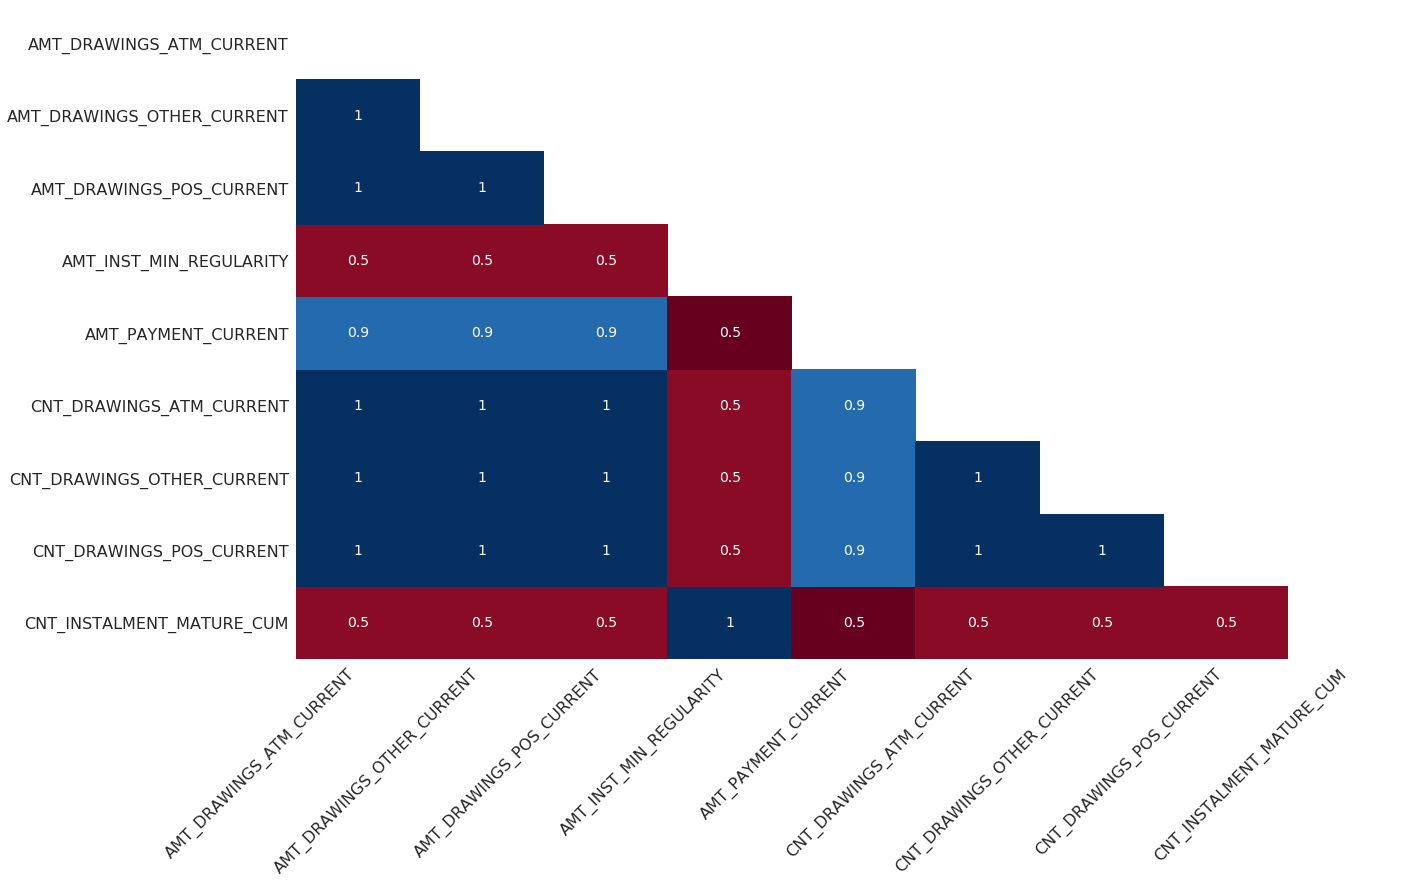

In [165]:
msno.heatmap(cre_balance[cre_balance.columns[cre_balance.isna().any()].tolist()])

In [135]:
missing = cre_balance.columns[cre_balance.isna().any()].tolist()
missing

['AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM']

In [136]:
cre_balance.loc[:,missing].min()

AMT_DRAWINGS_ATM_CURRENT     -6827.31
AMT_DRAWINGS_OTHER_CURRENT       0.00
AMT_DRAWINGS_POS_CURRENT         0.00
AMT_INST_MIN_REGULARITY          0.00
AMT_PAYMENT_CURRENT              0.00
CNT_DRAWINGS_ATM_CURRENT         0.00
CNT_DRAWINGS_OTHER_CURRENT       0.00
CNT_DRAWINGS_POS_CURRENT         0.00
CNT_INSTALMENT_MATURE_CUM        0.00
dtype: float64

In [137]:
cre_balance.loc[:,missing].max()

AMT_DRAWINGS_ATM_CURRENT      2115000.000
AMT_DRAWINGS_OTHER_CURRENT    1529847.000
AMT_DRAWINGS_POS_CURRENT      2239274.160
AMT_INST_MIN_REGULARITY        202882.005
AMT_PAYMENT_CURRENT           4289207.445
CNT_DRAWINGS_ATM_CURRENT           51.000
CNT_DRAWINGS_OTHER_CURRENT         12.000
CNT_DRAWINGS_POS_CURRENT          165.000
CNT_INSTALMENT_MATURE_CUM         120.000
dtype: float64

In [35]:
# Fill all variables with -1
cre_balance = cre_balance.fillna(-1)

### NaN in Bureau_balance

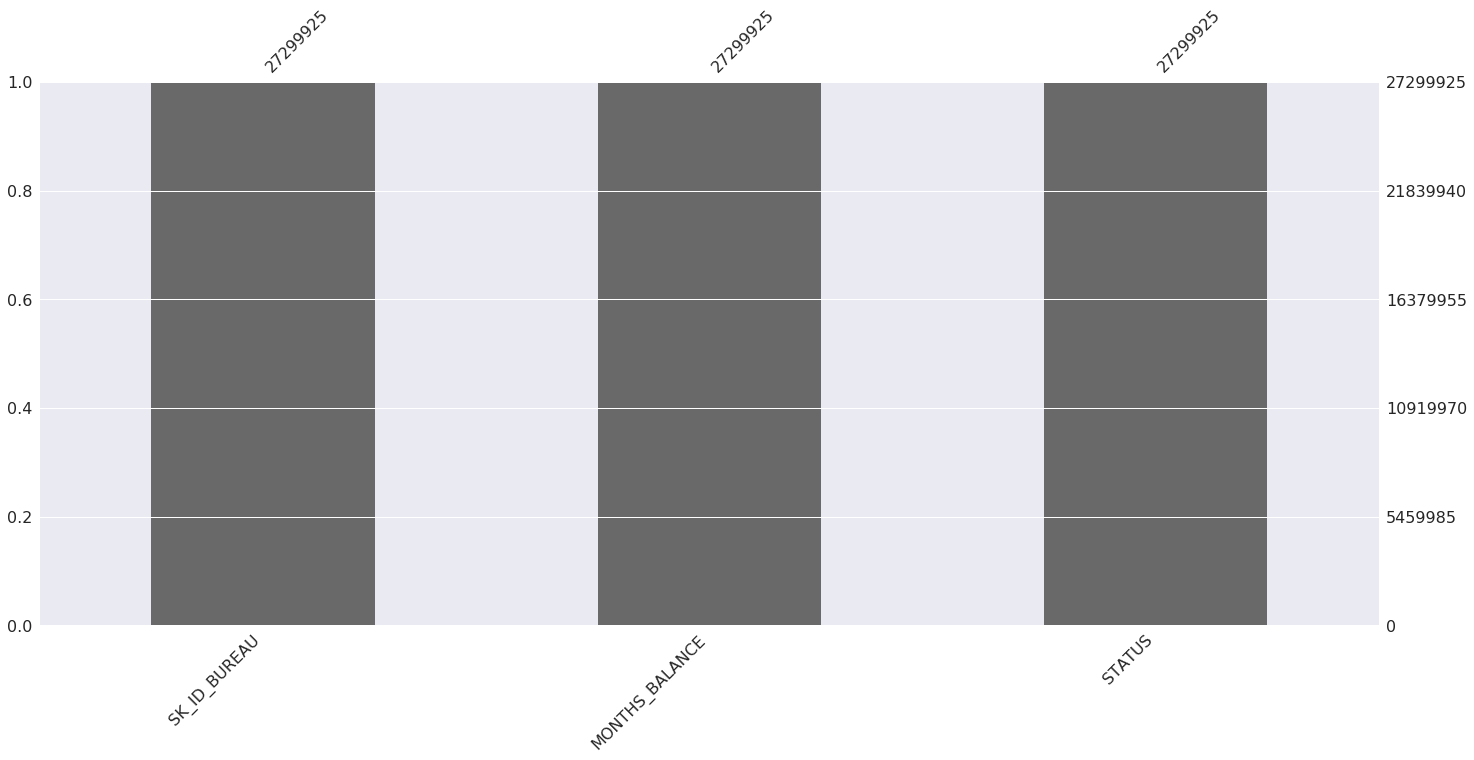

In [157]:
msno.bar(bureau_balance)

In [166]:
bureau_balance.columns[bureau_balance.isna().any()].tolist()

[]

### NaN in POS_cash_balance

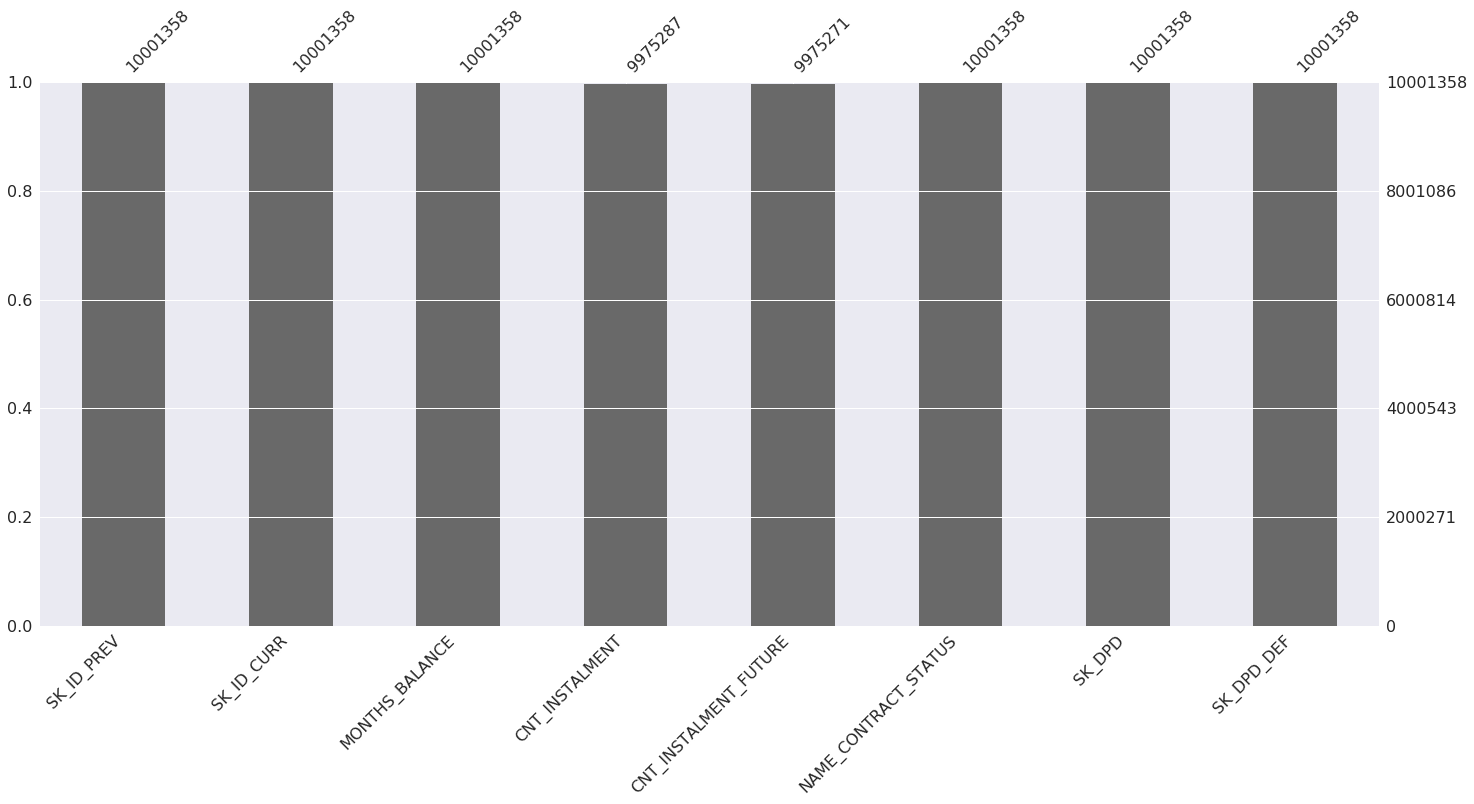

In [158]:
msno.bar(POS_balance.iloc[:,:])

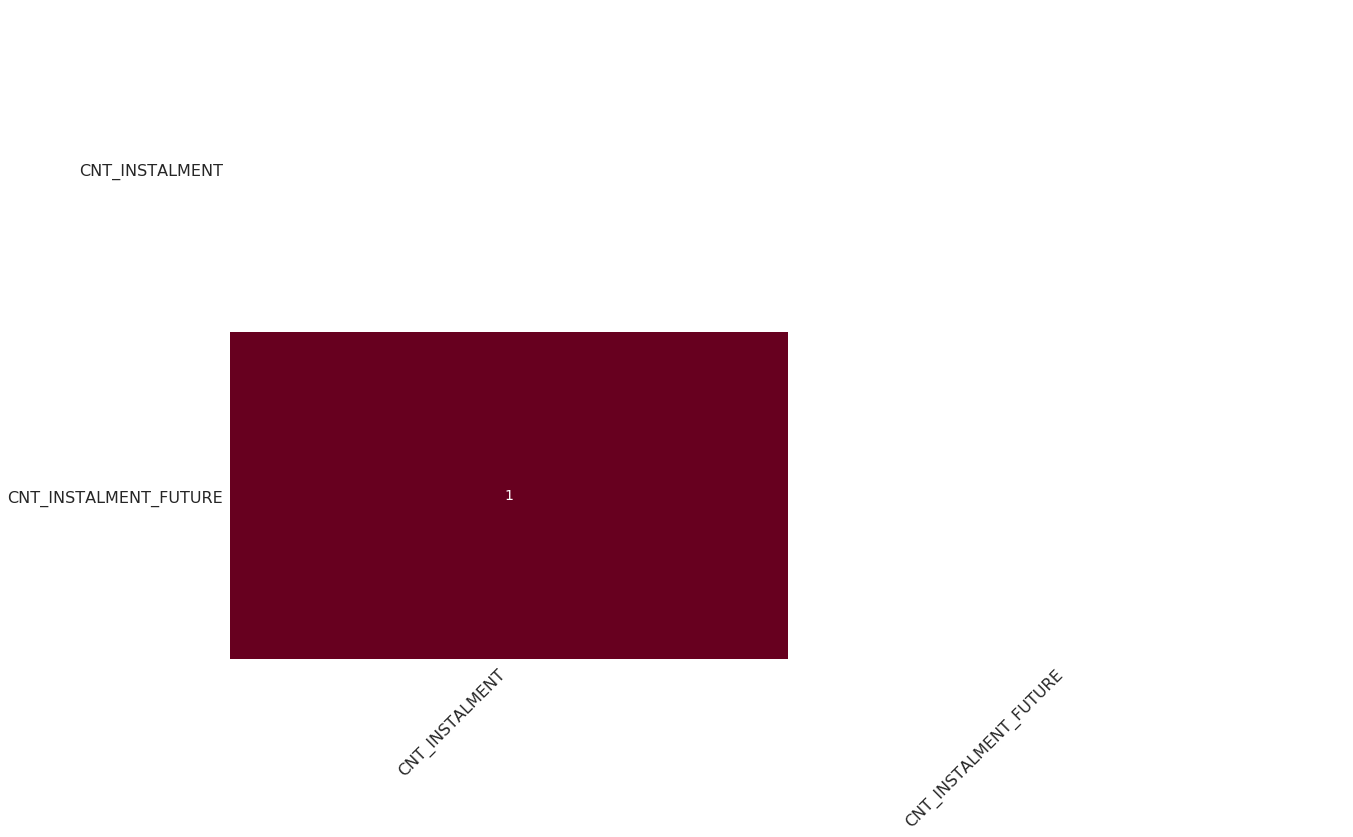

In [172]:
msno.heatmap(POS_balance[POS_balance.columns[POS_balance.isna().any()].tolist()])

In [167]:
POS_balance.columns[POS_balance.isna().any()].tolist()

['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']

In [173]:
POS_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


Missing values for CNT_INSTALMENT and CNT_INSTALMENT_FUTURE could be negative number。

In [37]:
POS_balance = POS_balance.fillna(-1)

### Nan in installments_payments

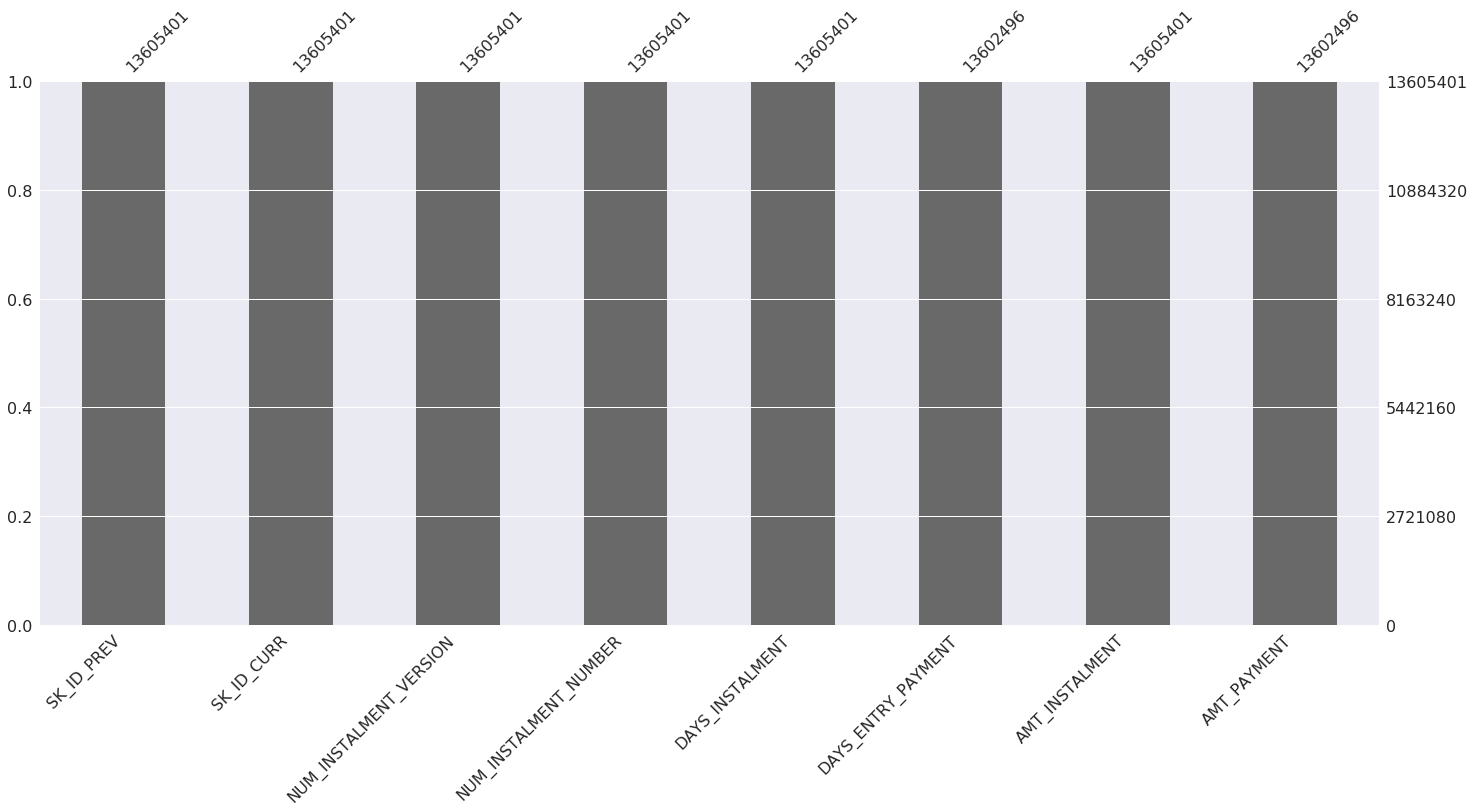

In [160]:
msno.bar(ins_payments.iloc[:,:])

In [168]:
ins_payments.columns[ins_payments.isna().any()].tolist()

['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']

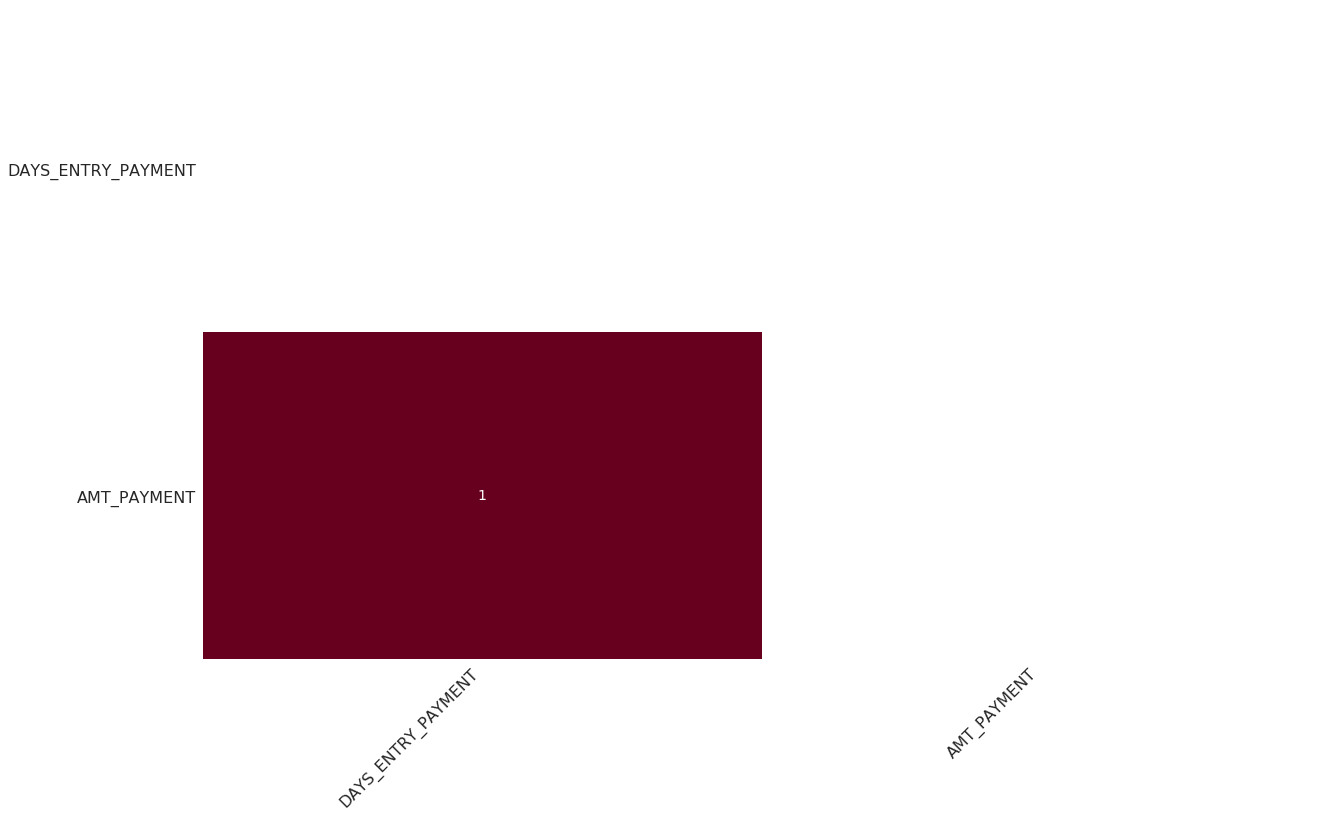

In [174]:
msno.heatmap(ins_payments[ins_payments.columns[ins_payments.isna().any()].tolist()])

In [175]:
ins_payments[ins_payments.columns[ins_payments.isna().any()].tolist()].describe()

,DAYS_ENTRY_PAYMENT,AMT_PAYMENT
count,1.360250e+07,1.360250e+07
mean,-1.051114e+03,1.723822e+04
std,8.005859e+02,5.473578e+04
min,-4.921000e+03,0.000000e+00
25%,-1.662000e+03,3.398265e+03
50%,-8.270000e+02,8.125515e+03
75%,-3.700000e+02,1.610842e+04
max,-1.000000e+00,3.771488e+06


As usual, 1 as filled values for missing values in DAYS_ENTRY_PAYMENT, and -1 for AMT_PAYMENT

In [38]:
ins_payments['DAYS_ENTRY_PAYMENT'].fillna(1, inplace = True)
ins_payments['AMT_PAYMENT'].fillna(-1, inplace = True)

In [39]:
# Label encoding for application train and test sets
def LabelEncode4application(df, df1):
        classe = []
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            classes = []
            try:
                # Convert null into a category for train set
                df.loc[pd.isnull(df[feature]),feature] = 'NaN'
                # Labelencoding for train set
                df[feature] = le.fit_transform(df[feature])
                # Convert null into a category for test set
                df1.loc[pd.isnull(df1[feature]),feature] = 'NaN'
                # Labelencoding for test set
                df1[feature] = le.transform(df1[feature])
            except:
                print('Error encoding '+feature)
        return df, df1

"""for file in filelist:
  file = LabelEncode(file)""" 
app_train, app_test = LabelEncode4application(app_train, app_test)

# Label encoding for all the other dataframes
def LabelEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                # Convert null into a category for train set
                df.loc[pd.isnull(df[feature]),feature] = 'NaN'
                # Labelencoding for train set
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df
      
filelist = (bureau,bureau_balance,cre_balance,ins_payments,pre_application,POS_balance)
for file in filelist:
  file = LabelEncode(file)

## Correlations

Only the correlations between numerical variables are being checked as the values of label-encoded categorical variables are not really meaningful.

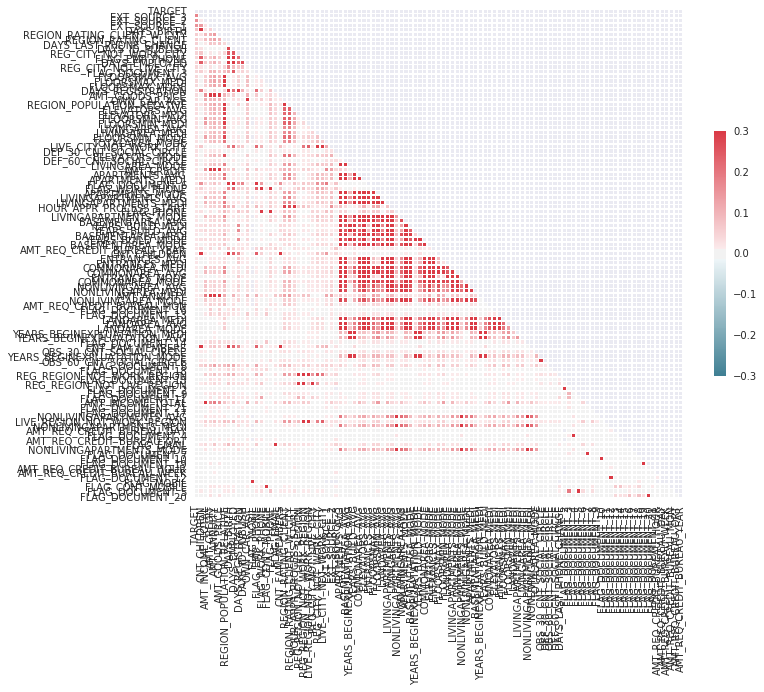

In [18]:
# Compute the correlation matrix
corr = app_train.iloc[:,1:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Alternatively consider correlation matrix clustering


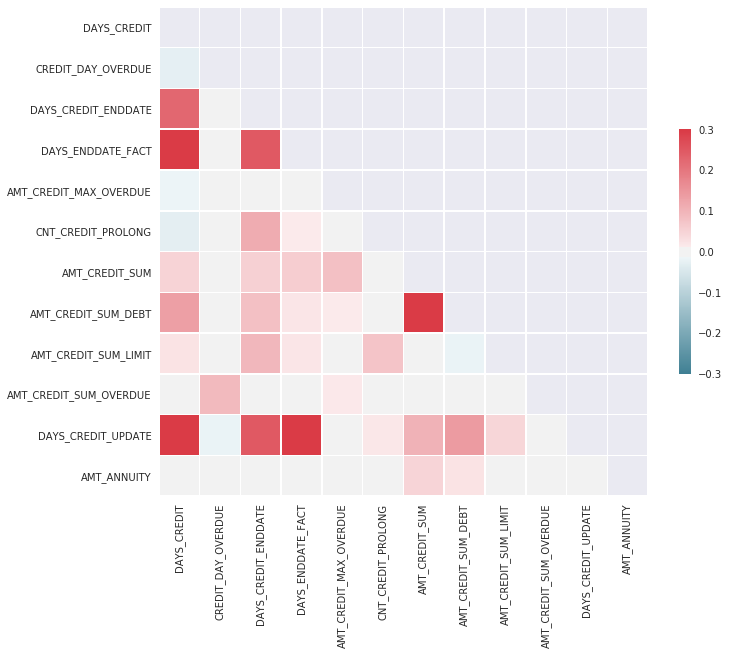

In [12]:
# Compute the correlation matrix
corr = bureau.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Alternatively consider correlation matrix clustering

In [24]:
bureau_balance.iloc[:,:].head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


It is not really meaningful to calculate the correlation for bureau_balance given the nature of the only two features.

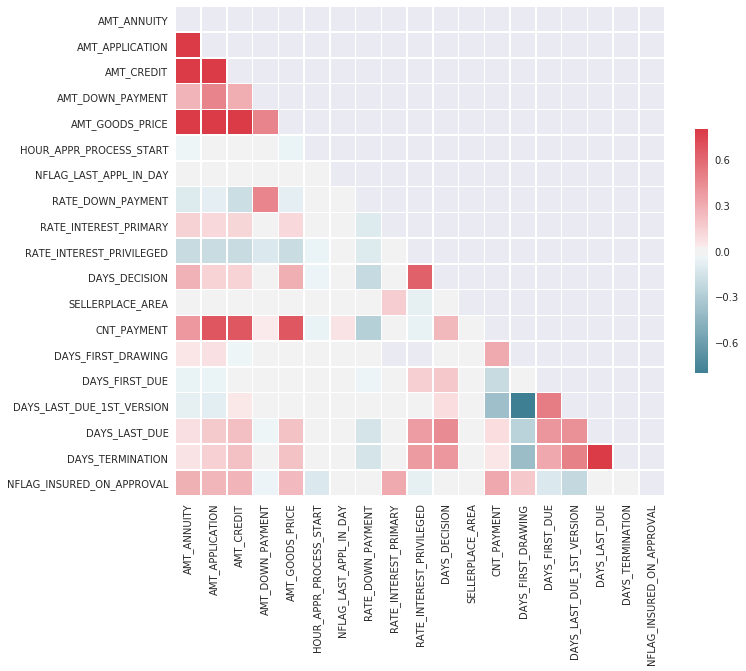

In [14]:
# Compute the correlation matrix
corr = pre_application.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Alternatively consider correlation matrix clustering

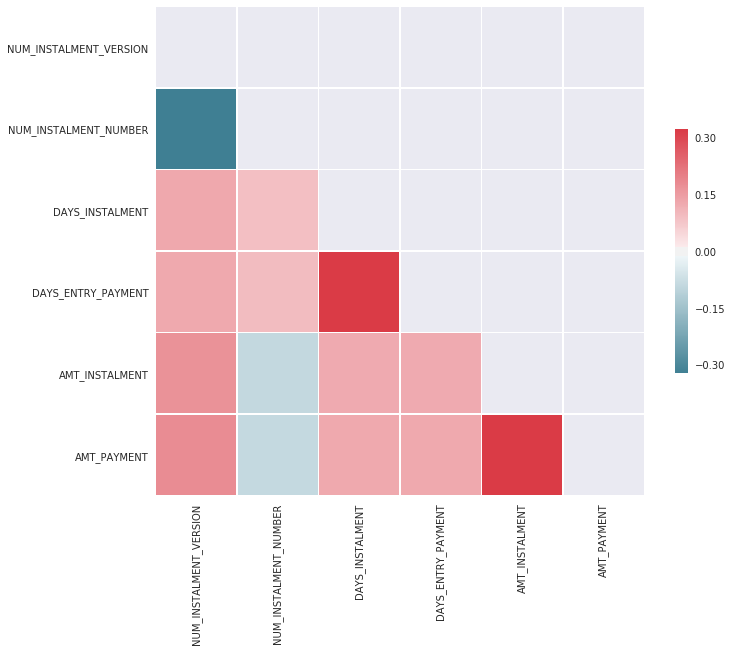

In [15]:
# Compute the correlation matrix
corr = ins_payments.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Alternatively consider correlation matrix clustering

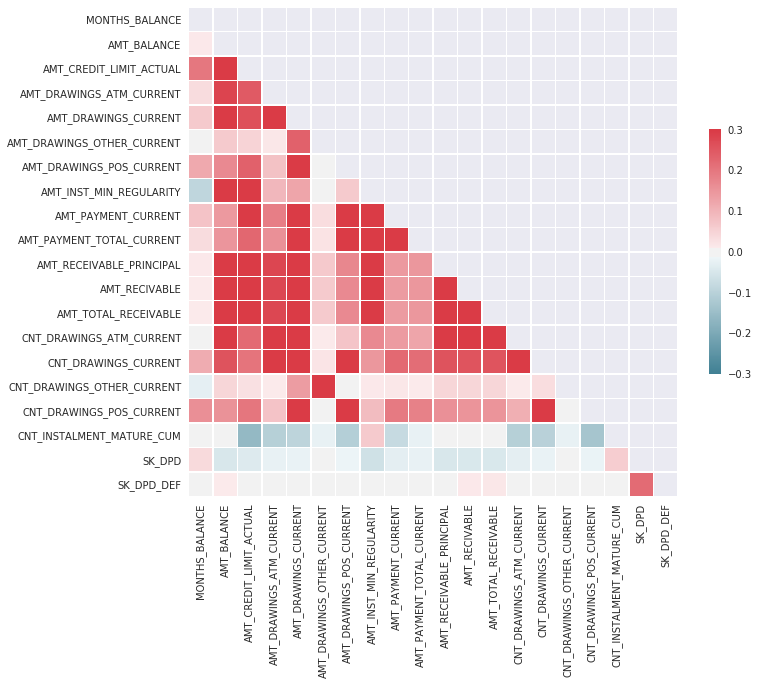

In [25]:
# Compute the correlation matrix
corr = cre_balance.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Alternatively consider correlation matrix clustering

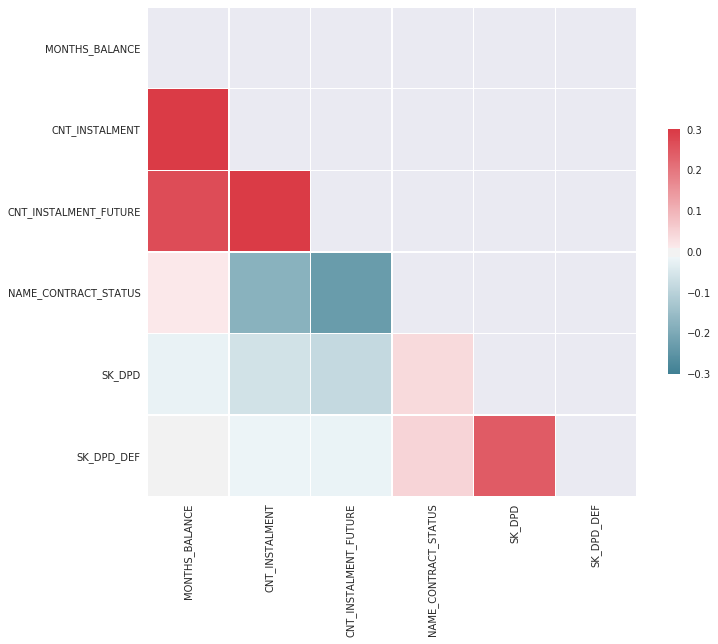

In [44]:
# Compute the correlation matrix
corr = POS_balance.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Alternatively consider correlation matrix clustering

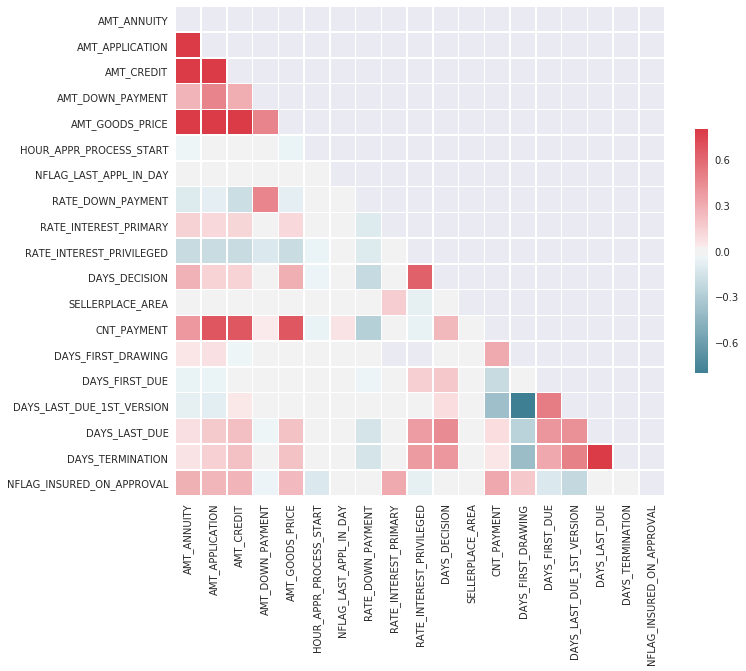

In [26]:
# Compute the correlation matrix
corr = pre_application.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Alternatively consider correlation matrix clustering

### Findings from the Correlation Matrix:
1. There are a great proportion of features in the "application_train" dataframe that are highly correlated with each other, as well as those that are nearly independent with all the rest. This calls for the feature selection process to eliminate highly correlated features and redundant features. More importantly, the potential ways of combining raw features to generate more meaningful features. This should add great value to the predictive power of our model.


2. Another implication would be that time series features should be engineered in some way to dig out their values. For example, in the "previous application" dataframe, DAYS_FIRST_DUE and DAYS_LAST_DUE_1ST_VERSION and DAYS_TERMINATION are correlated with each other, and obviously correlated to the target variable. Division between them, however, seems to give more insights about an applicant's previous behavior.


3. By the same token, those monetary features should not treated as indirect input. Rather, the division or multiplication between some of them are more relevant. For example, AMT_ANNUIT/AMT_APPLICATION/AMT_GOODS_PRICE could potentially reveal more about the loan repayment ability. In comparison, the raw features do not necessarily relate to the targe variable. 


4. For each applicant, he/she has multiple records for his/her credit cards/previous loans/install payments/etc. It is necessary to convert the those multiple records to a single row for each applicant. There are unlimited ways of doing that. And we should look for domain knowledge and some trial-and-errors to assist in extracting useful information. 

In [97]:
MeanMedian = app_train.describe().iloc[[1,5],1:].T
filelist = (bureau,bureau_balance,cre_balance,ins_payments,pre_application,POS_balance)

for file in filelist:
  MeanMedian = MeanMedian.append(file.describe().iloc[[1,5],2:].T)

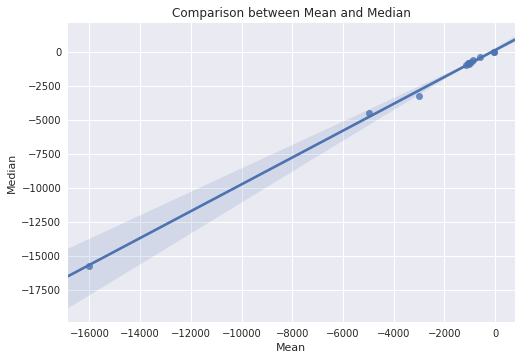

In [98]:
# Comparison between mean and median for mean < 0
ax = sns.regplot(MeanMedian.loc[MeanMedian['mean'] < 0,'mean'], 
                     MeanMedian.loc[MeanMedian['mean'] < 0,'50%'])
ax.set(xlabel = "Mean", ylabel = "Median", title = "Comparison between Mean and Median")
plt.show()

In [101]:
MeanMedian.loc[MeanMedian['mean'] < 0,:].index

Index(['DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_CREDIT', 'DAYS_ENDDATE_FACT',
       'DAYS_CREDIT_UPDATE', 'MONTHS_BALANCE', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'DAYS_DECISION', 'MONTHS_BALANCE'],
      dtype='object')

Features with negative mean are usually the days before a particular events. Their mean and median are quite consistent, indicating rare outliers. 

In [120]:
# Fill missing values


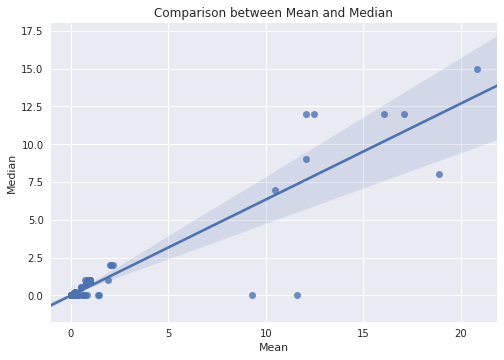

In [103]:
# Comparison between mean and median for mean between 0 and 1000
ax = sns.regplot(MeanMedian.loc[(MeanMedian['mean'] >= 0)&(MeanMedian['mean'] < 25),'mean'], 
                     MeanMedian.loc[(MeanMedian['mean'] >= 0)&(MeanMedian['mean'] < 25),'50%'])
ax.set(xlabel = "Mean", ylabel = "Median", title = "Comparison between Mean and Median")
plt.show()

In [106]:
MeanMedian.loc[(MeanMedian['mean'] >= 0)&(MeanMedian['mean'] < 25),:].index

Index(['TARGET', 'CNT_CHILDREN', 'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL',
       ...
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'CNT_PAYMENT', 'NFLAG_INSURED_ON_APPROVAL',
       'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF'],
      dtype='object', length=118)

The variables with mean between 0 and 25 include types like the counts of certain objects or certain events, binary variables. A great proportion of them have zero as the majority of values. This indicates that the missing values should not classified as 0. Instead, it could be classified as something else. XGBoost can automatically classify all missing values as a different class. For other non-tree-based models, the missing values are replaced by the mean, which is not likely to be zero.

In [121]:
# Fill Missing values

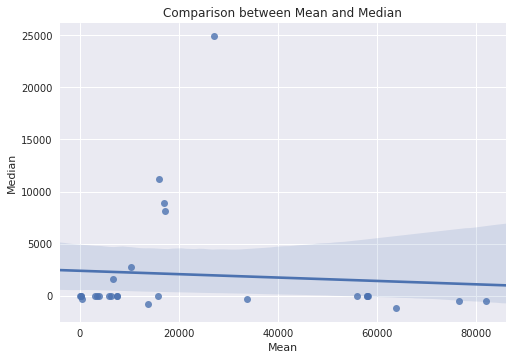

In [110]:
# Comparison between mean and median for mean between 0 and 1000
ax = sns.regplot(MeanMedian.loc[(MeanMedian['mean'] >= 25)&(MeanMedian['mean'] < 100000),'mean'], 
                     MeanMedian.loc[(MeanMedian['mean'] >= 25)&(MeanMedian['mean'] < 100000),'50%'])
ax.set(xlabel = "Mean", ylabel = "Median", title = "Comparison between Mean and Median")
plt.show()

In [111]:
MeanMedian.loc[(MeanMedian['mean'] >= 25)&(MeanMedian['mean'] < 100000),:].index

Index(['AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_CREDIT_ENDDATE',
       'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY', 'AMT_BALANCE',
       'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT',
       'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT',
       'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT',
       'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL',
       'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'AMT_INSTALMENT',
       'AMT_PAYMENT', 'AMT_ANNUITY', 'AMT_DOWN_PAYMENT', 'SELLERPLACE_AREA',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION'],
      dtype='object')

The majority of features with mean between 0 and 1000 are monetary features with median of 0. Therefore, the imputation for missing values could be mean. 

In [123]:
# Fill missing values

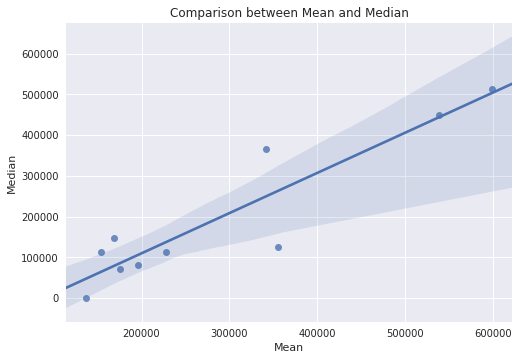

In [112]:
# Comparison between mean and median for mean greater than 10000
ax = sns.regplot(MeanMedian.loc[MeanMedian['mean'] >= 100000,'mean'], 
                     MeanMedian.loc[MeanMedian['mean'] >= 100000,'50%'])
ax.set(xlabel = "Mean", ylabel = "Median", title = "Comparison between Mean and Median")
plt.show()

In [113]:
MeanMedian.loc[MeanMedian['mean'] > 100000,:].index

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_APPLICATION',
       'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_FIRST_DRAWING'],
      dtype='object')

The discrenpancy between mean and median here indicate that the deviation away from normal distribution. However, multiplication/division between monetary values could potentially offset the effect of outliers, since the rows that have extreme values in certain columns are more likely to have extreme values in correlated columns. Division/multiplication could mitigate this issue. Apart from that, taking the log or power transformation / normalization or quantile transformation for monetary features could help this issue as well.

In [124]:
# Fill missing values

## Key Variables

### Distribution of Target Variable

[Text(0,0.5,'Counts'),
 Text(0.5,0,'Default'),
 Text(0.5,1,'Distribution of Default/Non-Default')]

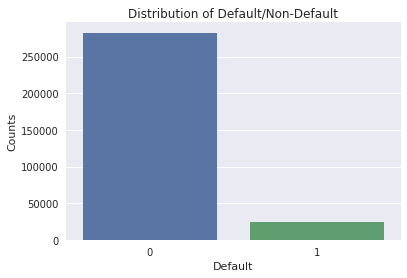

In [43]:
ax = sns.countplot(app_train['TARGET'])
ax.set(xlabel='Default', ylabel='Counts', title = 'Distribution of Default/Non-Default')

In [36]:
corr = app_train.iloc[:,1:].corr()
abs(corr['TARGET']).sort_values(ascending = False)[:10]

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_EDUCATION_TYPE            0.054699
CODE_GENDER                    0.054692
Name: TARGET, dtype: float64

In [4]:
corr = app_train.iloc[:,1:].corr()
abs(corr['TARGET']).sort_values(ascending = False)[:10]

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
Name: TARGET, dtype: float64

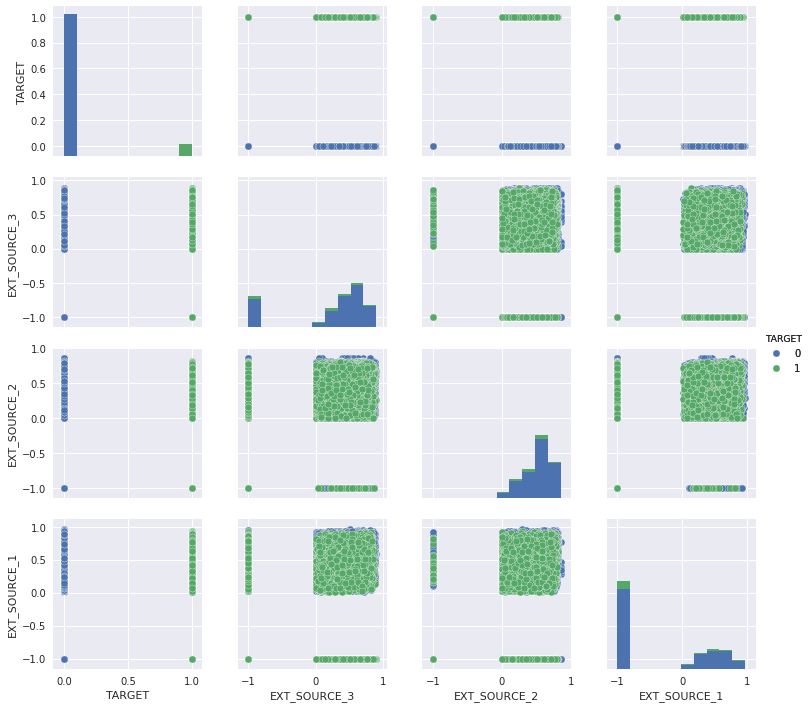

In [14]:
Keyvar = abs(corr['TARGET']).sort_values(ascending = False)[:4].index.values
g = sns.pairplot(app_train.loc[:,Keyvar].fillna(-1), hue="TARGET")
g.add_legend()

This set of pairplot shows the distribution of the target variable along with three features that are most correlated with the target. These three are scores normalized from external data. They are all normalized between 0 and 1, with a significantly proportion of EXT_SOURCE_1 missing, and some proportion of EXT_SOURCE_3 missing. Given the previous correlation matrix, we found that

In [42]:
corr1 = abs(corr.loc[:,'EXT_SOURCE_1']).sort_values(ascending = False)[1:10]
corr1.to_frame().style.background_gradient()

,EXT_SOURCE_1
DAYS_BIRTH,0.60061
FLAG_EMP_PHONE,0.294147
DAYS_EMPLOYED,0.289848
EXT_SOURCE_2,0.213982
FLAG_DOCUMENT_6,0.190874
EXT_SOURCE_3,0.186846
REG_CITY_NOT_WORK_CITY,0.185953
DAYS_REGISTRATION,0.181095
AMT_GOODS_PRICE,0.175502


In [41]:
corr2 = abs(corr.loc[:,'EXT_SOURCE_2']).sort_values(ascending = False)[1:10]
corr2.to_frame().style.background_gradient()

,EXT_SOURCE_2
REGION_RATING_CLIENT,0.292895
REGION_RATING_CLIENT_W_CITY,0.288299
EXT_SOURCE_1,0.213982
REGION_POPULATION_RELATIVE,0.198924
DAYS_LAST_PHONE_CHANGE,0.195764
TARGET,0.160472
HOUR_APPR_PROCESS_START,0.156863
AMT_GOODS_PRICE,0.139367
FLOORSMAX_AVG,0.135863


In [40]:
corr3 = abs(corr.loc[:,'EXT_SOURCE_3']).sort_values(ascending = False)[1:10]
corr3.to_frame().style.background_gradient()

,EXT_SOURCE_3
DAYS_BIRTH,0.205478
EXT_SOURCE_1,0.186846
TARGET,0.178919
DAYS_ID_PUBLISH,0.131597
FLAG_EMP_PHONE,0.115293
DAYS_EMPLOYED,0.113434
EXT_SOURCE_2,0.109167
DAYS_REGISTRATION,0.107549
REG_CITY_NOT_WORK_CITY,0.079729


These external scores are correlated with other attributes of an applicant, which makes them even stronger predictors of target variable.

In [101]:
# Exclude missing values
summary = app_train.loc[:,Keyvar].describe().round(3)
summary

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1
count,307511.000,246546.000,306851.000,134133.000
mean,0.081,0.511,0.514,0.502
std,0.272,0.195,0.191,0.211
min,0.000,0.001,0.000,0.015
25%,0.000,0.371,0.392,0.334
50%,0.000,0.535,0.566,0.506
75%,0.000,0.669,0.664,0.675
max,1.000,0.896,0.855,0.963


In [119]:
# Compute the skewness and kurtosis for the each external score
Nsummary = np.zeros(shape=(2,4))
col = ['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1']

for i in np.arange(1,4):
  Nsummary[0,i] = skew(app_train.loc[:,col[i-1]].dropna())
  Nsummary[1,i] = kurtosis(app_train.loc[:,col[i-1]].dropna()) + 3
  
Nsummary[[0,1],0] = np.nan 
Nsummary = pd.DataFrame(data = Nsummary, index = ['skew','kurt'], columns = summary.columns)
pd.concat([summary,Nsummary]).round(3)

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1
count,307511.000,246546.000,306851.000,134133.000
mean,0.081,0.511,0.514,0.502
std,0.272,0.195,0.191,0.211
min,0.000,0.001,0.000,0.015
25%,0.000,0.371,0.392,0.334
50%,0.000,0.535,0.566,0.506
75%,0.000,0.669,0.664,0.675
max,1.000,0.896,0.855,0.963
skew,NaN,-0.409,-0.794,-0.069
kurt,NaN,2.337,2.731,2.035


External scores seem to be a little bit right skewed with tail thinner than normal distribution, and mean at around 0.5, standard deviation at around 0.2.

## Feature Engineering

In [48]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

In [50]:
app = app_train
previous = pre_application
cash = POS_balance
installments = ins_payments
credit = cre_balance

In [51]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

In [53]:
# Relationship between app and bureau; linked by ID
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance; linked by Bureau ID
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [54]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 9]
    credit [Rows: 3840312, Columns: 24]
    bureau_balance [Rows: 27299925, Columns: 4]
    bureau [Rows: 1716428, Columns: 17]
    app [Rows: 307511, Columns: 122]
    previous [Rows: 1670214, Columns: 37]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [65]:
credit.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

## Writing CSV FIles to Storage

In [44]:
# Export as csv files
app_train.to_csv('application_train.csv', encoding='utf-8', index=False)
app_test.to_csv('application_test.csv', encoding='utf-8', index=False)
bureau.to_csv('bureau.csv', encoding='utf-8', index=False)
bureau_balance.to_csv('bureau_balance.csv', encoding='utf-8', index=False)
ins_payments.to_csv('installments_payments.csv', encoding='utf-8', index=False)
cre_balance.to_csv('credit_card_payments.csv', encoding='utf-8', index=False)
POS_balance.to_csv('POS_CASH_balance.csv', encoding='utf-8', index=False)
pre_application.to_csv('previous_application.csv', encoding='utf-8', index=False)

# Copy csv files from local machine to Storage Bucket
!gsutil cp 'application_train.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/application_train.csv'
!gsutil cp 'application_test.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/application_test.csv'
!gsutil cp 'bureau.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/bureau.csv'
!gsutil cp 'bureau_balance.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/bureau_balance.csv'
!gsutil cp 'installments_payments.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/installments_payments.csv'
!gsutil cp 'credit_card_payments.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/credit_card_payments.csv'
!gsutil cp 'POS_CASH_balance.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/POS_CASH_balance.csv'
!gsutil cp 'previous_application.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/previous_application.csv'

Copying file://bureau.csv [Content-Type=text/csv]...
| [1 files][132.5 MiB/132.5 MiB]                                                
Operation completed over 1 objects/132.5 MiB.                                    
Copying file://bureau_balance.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][358.2 MiB/358.2 MiB]     